# Import CSV to Dataframe

In [1]:
import pandas as pd
df = pd.read_csv('/home/victorjuettner/Nextcloud/Uni/iot-praktikum/preprocessing/tuya.csv', header=0, sep='\t', dtype='unicode') 
df.columns = df.columns.astype('str').str.replace(r".", r"", regex=False)

### Unbekannte Objekte in nummerisches Format überführen

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   _wscolProtocol  617 non-null    object
 1   frametime       617 non-null    object
 2   ipsrc           617 non-null    object
 3   ipdst           617 non-null    object
 4   tcpsrcport      389 non-null    object
 5   tcpdstport      389 non-null    object
 6   udpsrcport      228 non-null    object
 7   udpdstport      228 non-null    object
dtypes: object(8)
memory usage: 38.7+ KB


### Uhrzeit

In [3]:
df.frametime = pd.to_datetime(df.frametime, format="%b %d, %Y %H:%M:%S.%f CEST" )

### IP-Adressen

In [4]:
import ipaddress
# Remove tshark error with 2 destination adresses
df['ipdst'] = df['ipdst'].apply(lambda x: x.split(',')[0] if ',' in x else x)
df['ipsrc'] = df['ipsrc'].apply(lambda x: x.split(',')[0] if ',' in x else x)

df['ipsrc'] = df['ipsrc'].apply(lambda x: int(ipaddress.ip_address(x)))
df['ipdst'] = df['ipdst'].apply(lambda x: int(ipaddress.ip_address(x)))

### Ports

In [5]:
df['srcport'] = df['tcpsrcport'].fillna(0).astype(int) + df['udpsrcport'].fillna(0).astype(int)
df['dstport'] = df['tcpdstport'].fillna(0).astype(int) + df['udpdstport'].fillna(0).astype(int)
del df['tcpsrcport'], df['udpsrcport'], df['tcpdstport'], df['udpdstport']

### Protokoll

In [6]:
#df._wscolProtocol.unique()
# https://www.iana.org/assignments/protocol-numbers/protocol-numbers.xhtml
protocol_dict = {
    'TLSv1.2': 56,
    'TCP': 6,
    'UDP': 17,
    'RTCP': 170,
    'ICMP': 1,
    'HTTP/JSON': 2,
    'HTTP': 3,
    'DHCP': 4,
    'IGMPv2': 5,
    'MDNS': 7,
    'CoAP': 8,
    'DNS': 9,
    'NTP': 10,
    'X11':11
}
df._wscolProtocol = df._wscolProtocol.map(protocol_dict)
df._wscolProtocol = df._wscolProtocol.fillna(0) 

In [7]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   _wscolProtocol  617 non-null    float64       
 1   frametime       617 non-null    datetime64[ns]
 2   ipsrc           617 non-null    int64         
 3   ipdst           617 non-null    int64         
 4   srcport         617 non-null    int64         
 5   dstport         617 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 29.1 KB


_wscolProtocol                  frametime       ipsrc       ipdst  srcport  \
0            17.0 2023-07-20 13:50:13.873407  3232235812  4294967295    49154   
1            17.0 2023-07-20 13:50:18.872392  3232235812  4294967295    49154   
2            17.0 2023-07-20 13:50:23.872751  3232235812  4294967295    49154   
3            17.0 2023-07-20 13:50:28.873044  3232235812  4294967295    49154   
4            17.0 2023-07-20 13:50:33.872933  3232235812  4294967295    49154   

   dstport  
0     6667  
1     6667  
2     6667  
3     6667  
4     6667

## Visualisierungen

### Frequenz

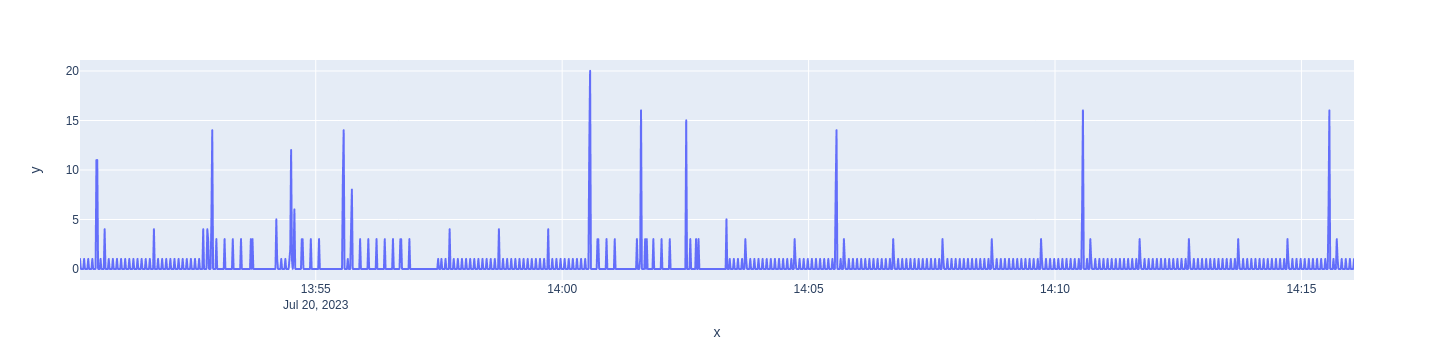

In [8]:
#https://plotly.com/python/
import plotly.express as px

frequency = df.groupby(pd.Grouper(key='frametime', freq="1S")).count().iloc[:,0]
fig = px.line(x=frequency.index, y=frequency.values)

fig.show()

In [9]:
df.to_pickle('/home/victorjuettner/Nextcloud/Uni/iot-praktikum/preprocessing/tuya.p')